In [68]:
import time
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

In [69]:
def to_celsius(image):
    """Convert raw intensity values of radiometric image to Celsius scale."""
    return image*0.04-273.15


def preprocess_radiometric_frame(frame, equalize_hist=True):
    """Preprocesses raw radiometric frame.

    First, the raw 16-bit radiometric intensity values are converted to Celsius
    scale. Then, the image values are normalized to range [0, 255] and converted
    to 8-bit. Finally, histogram equalization is performed to normalize
    brightness and enhance contrast.
    """
    frame = to_celsius(frame)
    frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
    frame = (frame*255.0).astype(np.uint8)
    if equalize_hist:
        frame = cv2.equalizeHist(frame)
        # CLAHE results in vastly different numbers of feature points depending on clipLimit
        #clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
        #frame = clahe.apply(frame)
    return frame

In [70]:
def extract_keypoints_orb(frame):
    """Extracts FAST feature points and ORB descriptors in the frame."""
    orb = cv2.ORB_create(nfeatures=5000, fastThreshold=12)
    kp = orb.detect(frame, None)
    kp, des = orb.compute(frame, kp)
    return kp, des

In [71]:
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
dist_coeffs = pickle.load(open("../camera_calibration/parameters/ir/dist_coeffs.pkl", "rb"))

img_w = 640
img_h = 512
new_camera_matrix = camera_matrix
mapx, mapy = cv2.initUndistortRectifyMap(
    camera_matrix, dist_coeffs, None,
    new_camera_matrix, (img_w, img_h), cv2.CV_32FC1)

In [72]:
def load_image(image_file):
    frame = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH)
    frame = preprocess_radiometric_frame(frame, equalize_hist=True
                                        )
    frame = cv2.remap(frame, mapx, mapy, cv2.INTER_CUBIC)
    return frame

img0 = load_image("frame_004923.tiff")
img1 = load_image("frame_004924.tiff")

#img0 = load_image("frame_004923.tiff")
#img1 = load_image("frame_004924.tiff")

In [73]:
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

kp0, des0 = extract_keypoints_orb(img0)
kp1, des1 = extract_keypoints_orb(img1)

print(len(kp0), len(kp1))

4297 4266


In [74]:
# global matching
distance_threshold = 20.0
matches = bf.match(des0, des1)
matches = sorted(matches, key=lambda x:x.distance)
matches = [m for m in matches if m.distance < distance_threshold]
print("Found {} matches of current frame with last key frame".format(len(matches)))

Found 1217 matches of current frame with last key frame


In [75]:
# filter match outliers with large deviation of spatial distance from median spatial distance

last_pts = np.array([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 2)
current_pts = np.array([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 2)

spatial_dists = np.linalg.norm(last_pts - current_pts, axis=1)

median_dist = np.median(spatial_dists)
print("Median spatial distance of matches: {}".format(median_dist))

threshold = 3.0
match_inlier_idxs = np.ravel(np.argwhere((spatial_dists > median_dist - threshold) & (spatial_dists < median_dist + threshold)))

matches = [matches[i] for i in match_inlier_idxs]
last_pts = last_pts[match_inlier_idxs]
current_pts = current_pts[match_inlier_idxs]

print(len(matches), last_pts.shape, current_pts.shape)

Median spatial distance of matches: 7.0
1118 (1118, 2) (1118, 2)


In [77]:
pts0 = np.array([kp0[m.queryIdx].pt for m in matches]).reshape(1, -1, 2)
pts1 = np.array([kp1[m.trainIdx].pt for m in matches]).reshape(1, -1, 2)

match_frame = np.zeros((*img1.shape, 3), dtype=np.uint8)

img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
for m in matches:
    pt1 = (int(kp0[m.queryIdx].pt[0]), int(kp0[m.queryIdx].pt[1]))
    pt2 = (int(kp1[m.trainIdx].pt[0]), int(kp1[m.trainIdx].pt[1]))
    img1 = cv2.line(img1, pt1, pt2, (255,0,0), 3)

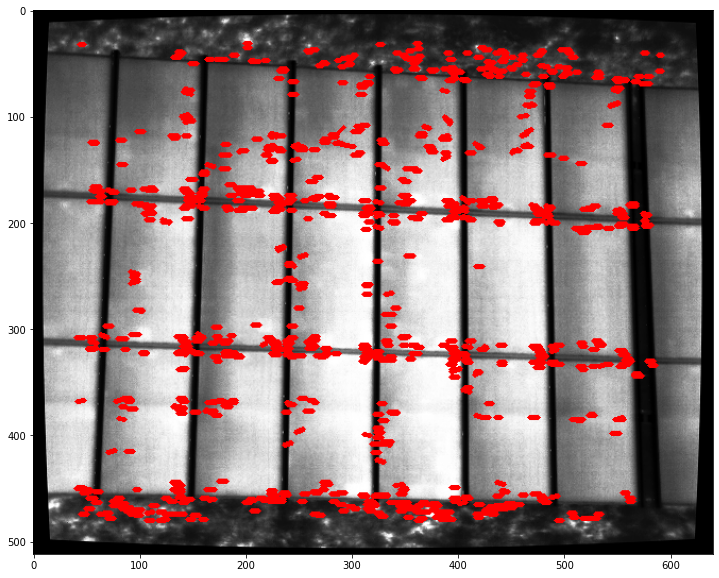

In [78]:
fig = plt.figure()
fig.set_size_inches(20, 10)
plt.imshow(img1)
plt.show()